### Read the station data from GHCN archive ###

Data obtained from http://www.ncdc.noaa.gov/cdo-web/

In [67]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
%matplotlib inline

In [72]:
def read_precip(fpath, prcp):
    print(fpath)
    for file in glob.glob(fpath):
        data_in = pd.read_csv(file)
        print(data_in.STATION_NAME[0])
        prcp[data_in.STATION_NAME[0]] = df.PRCP 
    #df.PRCP = np.array(df.PRCP)
    #mask = df.PRCP != 9999
    #df.PRCP[mask] = np.nan  
    return pd.DataFrame(prcp, index=dates)

In [73]:
prcp={}
df1 = read_precip(fpath="Data/*", prcp=prcp)

Data/*
KITALE KE
MOMBASA KE
MALINDI KE
GARISSA KE
JOMO KENYATTA INTERNATIONAL KE
NAIROBI DAGORETTI KE
ELDORET INTERNATIONAL KE
KITALE KE
LODWAR KE
MOYALE KE
MANDERA KE
JUBA OD
MWANZA TZ
DAR ES SALAAM AIRPORT TZ
TABORA AIRPORT TZ
DODOMA TZ
KIGALI INTERNATIONAL RW
ADDIS ABABA BOLE ET
JIMMA ET
DIREDAWA ET
GONDAR ET
GORE ET


In [74]:
df1

,ADDIS ABABA BOLE ET,DAR ES SALAAM AIRPORT TZ,DIREDAWA ET,DODOMA TZ,ELDORET INTERNATIONAL KE,GARISSA KE,GONDAR ET,GORE ET,JIMMA ET,JOMO KENYATTA INTERNATIONAL KE,...,KIGALI INTERNATIONAL RW,KITALE KE,LODWAR KE,MALINDI KE,MANDERA KE,MOMBASA KE,MOYALE KE,MWANZA TZ,NAIROBI DAGORETTI KE,TABORA AIRPORT TZ
1957-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
#plt.plot(df1)

In [27]:
prcp.keys()

['ADDIS ABABA BOLE ET',
 'LODWAR KE',
 'ELDORET INTERNATIONAL KE',
 'MOYALE KE',
 'DAR ES SALAAM AIRPORT TZ',
 'GARISSA KE',
 'JIMMA ET',
 'DIREDAWA ET',
 'GORE ET',
 'TABORA AIRPORT TZ',
 'DODOMA TZ',
 'JOMO KENYATTA INTERNATIONAL KE',
 'MOMBASA KE',
 'MWANZA TZ',
 'JUBA OD',
 'MANDERA KE',
 'KITALE KE',
 'MALINDI KE',
 'NAIROBI DAGORETTI KE',
 'KIGALI INTERNATIONAL RW',
 'GONDAR ET']

In [25]:
df = pd.read_csv("Data/598361.csv")

In [26]:
df.keys()

Index([u'STATION', u'STATION_NAME', u'ELEVATION', u'LATITUDE', u'LONGITUDE',
       u'DATE', u'PRCP', u'Measurement Flag', u'Quality Flag', u'Source Flag',
       u'Time of Observation', u'TMAX', u'Measurement Flag.1',
       u'Quality Flag.1', u'Source Flag.1', u'Time of Observation.1', u'TMIN',
       u'Measurement Flag.2', u'Quality Flag.2', u'Source Flag.2',
       u'Time of Observation.2'],
      dtype='object')

In [42]:
df.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,PRCP,Measurement Flag,Quality Flag,Source Flag,...,TMAX,Measurement Flag.1,Quality Flag.1,Source Flag.1,Time of Observation.1,TMIN,Measurement Flag.2,Quality Flag.2,Source Flag.2,Time of Observation.2
0,GHCND:KE000063820,MOMBASA KE,55,-4.033,39.617,19570101,NaN,,,Q,...,-9999,,,,9999,-9999,,,,9999
1,GHCND:KE000063820,MOMBASA KE,55,-4.033,39.617,19570102,NaN,,,Q,...,317,,,I,9999,233,,,I,9999
2,GHCND:KE000063820,MOMBASA KE,55,-4.033,39.617,19570103,NaN,,,Q,...,-9999,,,,9999,233,,,I,9999
3,GHCND:KE000063820,MOMBASA KE,55,-4.033,39.617,19570104,NaN,,,Q,...,317,,,I,9999,-9999,,,,9999
4,GHCND:KE000063820,MOMBASA KE,55,-4.033,39.617,19570105,NaN,,,Q,...,317,,,I,9999,233,,,I,9999


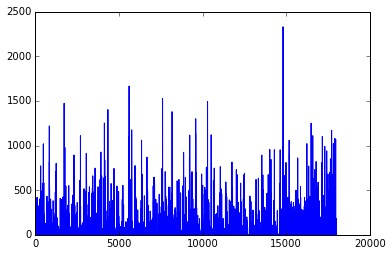

In [7]:
# Exaple of how to mask data and quick look
mask = df.PRCP != -9999
plt.plot(df.PRCP[mask])
plt.show()

In [8]:
# How to extract the head of the data
df.DATE.head()

0    19570101
1    19570102
2    19570103
3    19570104
4    19570105
Name: DATE, dtype: int64

In [9]:
print(df.DATE[0])
print(type(df.DATE[0]))
df.DATE[0]

19570101
<type 'numpy.int64'>


19570101

In [10]:
def get_date(date_number):
    """
    Turn the int64 value from the DATE of GHCN into a pd.datetime
    """
    dstring = str(date_number)
    return pd.datetime(int(dstring[0:4]),int(dstring[4:6]),int(dstring[6:8]))

In [11]:
get_date(df.DATE[0])

datetime.datetime(1957, 1, 1, 0, 0)

In [18]:
# How to create a pd.datetime index to subscript the data (IMPORTANT)
dates = [get_date(day) for day in df.DATE]

In [13]:
# How to put the index and the data of interest together into one frame
mydata = pd.DataFrame(data=df.PRCP.values,index=dates,columns=[df.STATION[0][6:]])

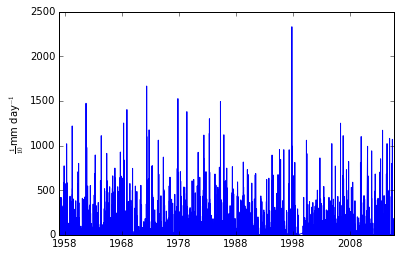

In [16]:
mask = mydata.KE000063820 != -9999
plt.plot(mydata.index[mask],mydata.KE000063820[mask])
plt.ylabel(r"$\frac{1}{10}$mm day$^{-1}$")

In [19]:
pd.concat([mydata.KE000063820,mydata.KE000063820,mydata.KE000063820, mydata.KE000063820],axis=1)

#mydata

,KE000063820,KE000063820,KE000063820,KE000063820
1957-01-01,0,0,0,0
1957-01-02,0,0,0,0
1957-01-03,0,0,0,0
1957-01-04,0,0,0,0
1957-01-05,18,18,18,18
1957-01-06,0,0,0,0
1957-01-07,175,175,175,175
1957-01-08,0,0,0,0
1957-01-09,0,0,0,0
1957-01-10,0,0,0,0
